In [17]:
# Projeto de Planejamento de Tarefas com Restrições (Dataset08)

# Importar bibliotecas necessárias
import pandas as pd
from constraint import Problem
import matplotlib.pyplot as plt
import seaborn as sns

# Função para dividir seções do arquivo
def parse_section(lines, start_marker, end_marker=None):
    start_index = next(i for i, line in enumerate(lines) if start_marker in line) + 1
    if end_marker:
        end_index = next((i for i, line in enumerate(lines[start_index:], start=start_index) if end_marker in line), len(lines))
        return lines[start_index:end_index]
    return lines[start_index:]

# Carregar o arquivo do Dataset08
dataset_path = 'C:/Users/Asus/OneDrive/Documents/3AnoLesi/IA/Projeto/p01_dataset_8/p01_dataset_08.txt'
with open(dataset_path, 'r') as file:
    lines = file.readlines()

# Processar as seções do arquivo
projects_summary = parse_section(lines, "#Projects summary", "************************************************************************")
precedence_relations = parse_section(lines, "#Precedence relations", "************************************************************************")
duration_resources = parse_section(lines, "#Duration and resources", "************************************************************************")
resource_availability = parse_section(lines, "#Resource availability", None)

# Criar DataFrames
projects_df = pd.DataFrame(
    [line.split() for line in projects_summary[1:]],
    columns=['pronr', '#jobs', 'rel.date', 'duedate', 'tardcost', 'MPM-Time']
).apply(pd.to_numeric, errors='coerce')

precedence_data = []
for line in precedence_relations[1:]:
    parts = line.split()
    jobnr, modes, successors = map(int, parts[:3])
    successors_list = list(map(int, parts[3:]))
    while len(successors_list) < 3:
        successors_list.append(None)
    precedence_data.append([jobnr, modes, successors] + successors_list)
precedence_df = pd.DataFrame(precedence_data, columns=['#jobnr', '#modes', '#successors', 'successor1', 'successor2', 'successor3'])

duration_df = pd.DataFrame(
    [line.split() for line in duration_resources[1:]],
    columns=['#jobnr', 'mode', 'duration', 'R1', 'R2']
).apply(pd.to_numeric, errors='coerce')

resources_data = [line.split() for line in resource_availability[1:] if line.strip() and not line.startswith("*")]
resources_df = pd.DataFrame(resources_data, columns=['#resource', 'qty'])
resources_df['qty'] = pd.to_numeric(resources_df['qty'], errors='coerce')

# Exibir DataFrames processados
print("Sumário de Projetos:")
print(projects_df)
print("\nRelações de Precedência:")
print(precedence_df)
print("\nDuração e Recursos:")
print(duration_df)
print("\nDisponibilidade de Recursos:")
print(resources_df)

# Criar problema CSP
problem = Problem()

# Adicionar variáveis
for _, row in duration_df.iterrows():
    problem.addVariable(row['#jobnr'], range(21))  # 0-20 (horizon definido)

# Adicionar restrições de precedência
for _, row in precedence_df.iterrows():
    job = row['#jobnr']
    successors = [s for s in [row['successor1'], row['successor2'], row['successor3']] if not pd.isna(s)]
    for successor in successors:
        problem.addConstraint(lambda t1, t2, d=duration_df.loc[duration_df['#jobnr'] == job, 'duration'].values[0]: t1 + d <= t2, (job, successor))

# Restrições de recursos
def resource_constraint(*args):
    times = dict(zip(duration_df['#jobnr'], args))
    for t in range(21):
        r1_usage = sum(
            duration_df.loc[duration_df['#jobnr'] == job, 'R1'].values[0]
            for job, start in times.items() if start <= t < start + duration_df.loc[duration_df['#jobnr'] == job, 'duration'].values[0]
        )
        r2_usage = sum(
            duration_df.loc[duration_df['#jobnr'] == job, 'R2'].values[0]
            for job, start in times.items() if start <= t < start + duration_df.loc[duration_df['#jobnr'] == job, 'duration'].values[0]
        )
        if r1_usage > resources_df.loc[resources_df['#resource'] == 'R1', 'qty'].values[0] or \
           r2_usage > resources_df.loc[resources_df['#resource'] == 'R2', 'qty'].values[0]:
            return False
    return True

problem.addConstraint(resource_constraint, duration_df['#jobnr'].tolist())

# Resolver
solution = problem.getSolution()
print("\nSolução encontrada:")
print(solution)



Sumário de Projetos:
   pronr  #jobs  rel.date  duedate  tardcost  MPM-Time
0      1      8         0       11         0        11

Relações de Precedência:
   #jobnr  #modes  #successors  successor1  successor2 successor3
0       1       1            2         2.0         3.0       None
1       2       1            1         4.0         NaN       None
2       3       1            1         4.0         NaN       None
3       4       1            0         NaN         NaN       None
4       5       1            2         6.0         7.0       None
5       6       1            1         8.0         NaN       None
6       7       1            1         8.0         NaN       None
7       8       1            0         NaN         NaN       None

Duração e Recursos:
   #jobnr  mode  duration  R1  R2
0       1     1         2   1   0
1       2     1         3   0   1
2       3     1         4   0   1
3       4     1         1   0   1
4       5     1         2   1   0
5       6     1         


--- Verificação de Valores Ausentes ---
Sumário de Projetos:
pronr       0
#jobs       0
rel.date    0
duedate     0
tardcost    0
MPM-Time    0
dtype: int64

Relações de Precedência:
#jobnr         0
#modes         0
#successors    0
successor1     2
successor2     6
successor3     8
dtype: int64

Duração e Recursos:
#jobnr      0
mode        0
duration    0
R1          0
R2          0
dtype: int64

Disponibilidade de Recursos:
#resource    0
qty          0
dtype: int64

--- Análise Estatística Básica ---

Sumário de Projetos:
       pronr  #jobs  rel.date  duedate  tardcost  MPM-Time
count    1.0    1.0       1.0      1.0       1.0       1.0
mean     1.0    8.0       0.0     11.0       0.0      11.0
std      NaN    NaN       NaN      NaN       NaN       NaN
min      1.0    8.0       0.0     11.0       0.0      11.0
25%      1.0    8.0       0.0     11.0       0.0      11.0
50%      1.0    8.0       0.0     11.0       0.0      11.0
75%      1.0    8.0       0.0     11.0       0.0    

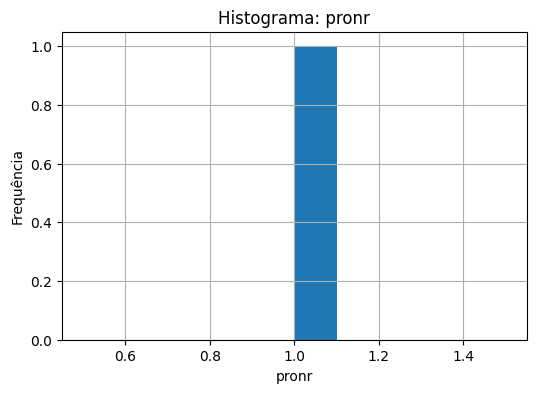

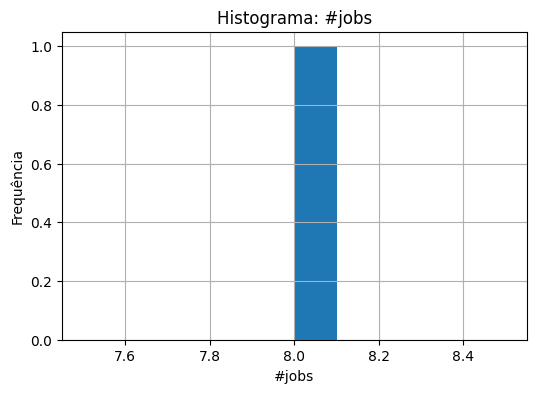

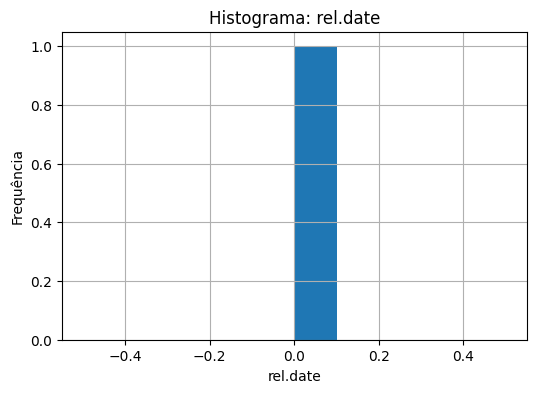

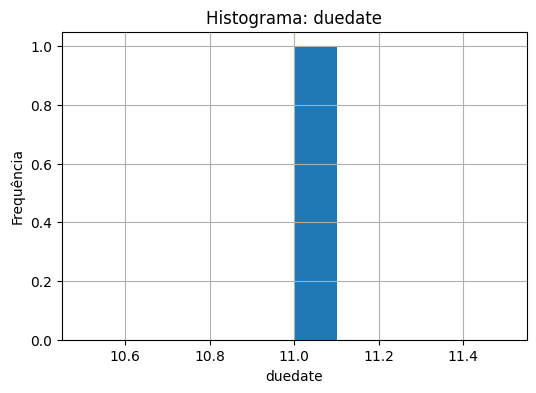

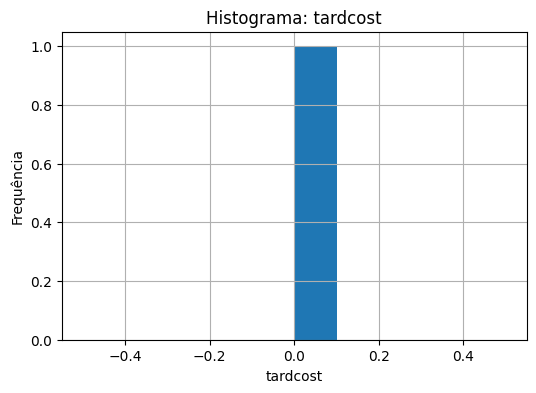

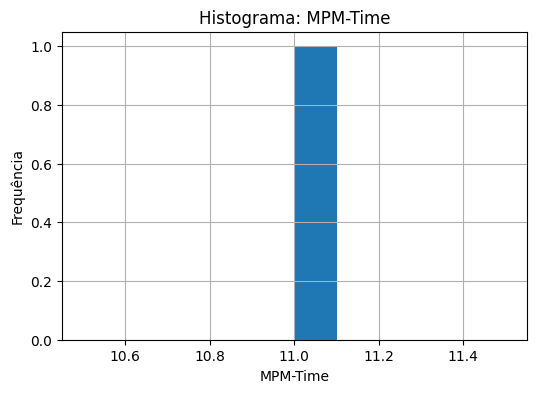

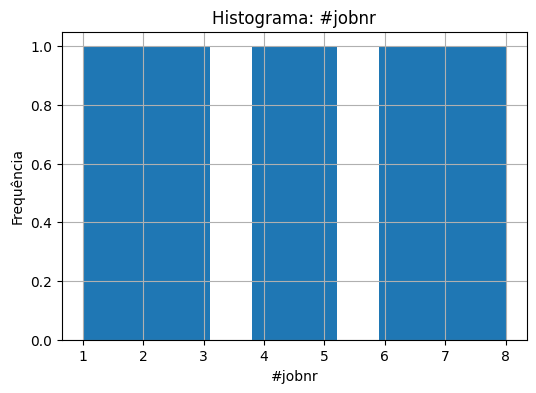

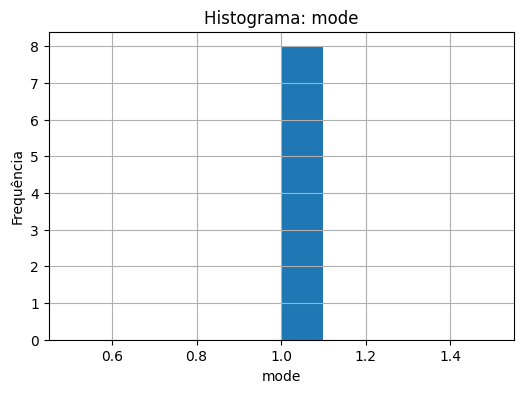

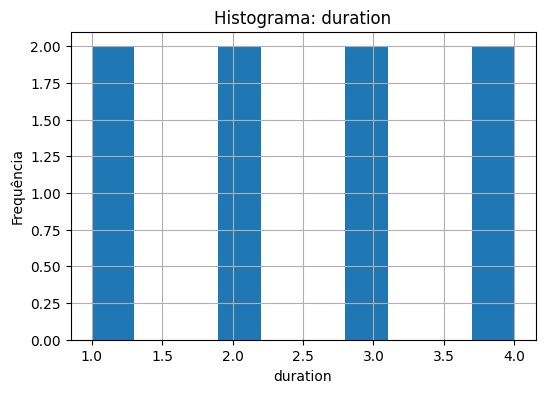

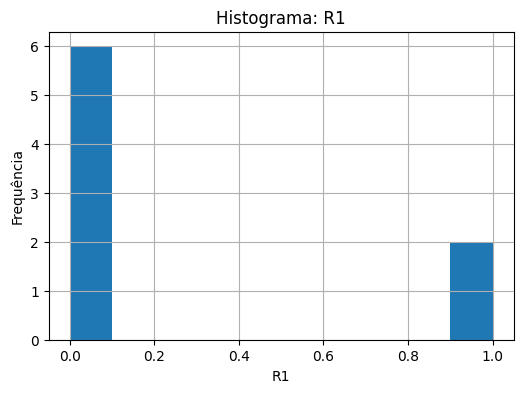

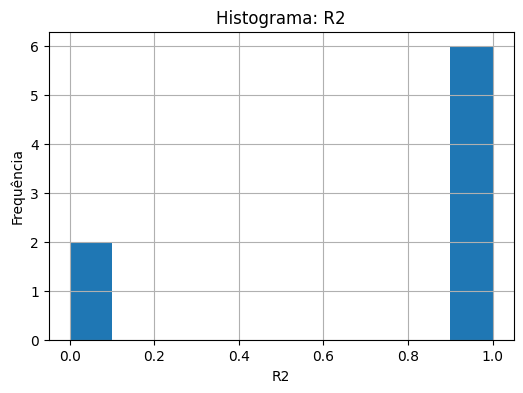


--- Visualização: Gráficos de Dispersão ---


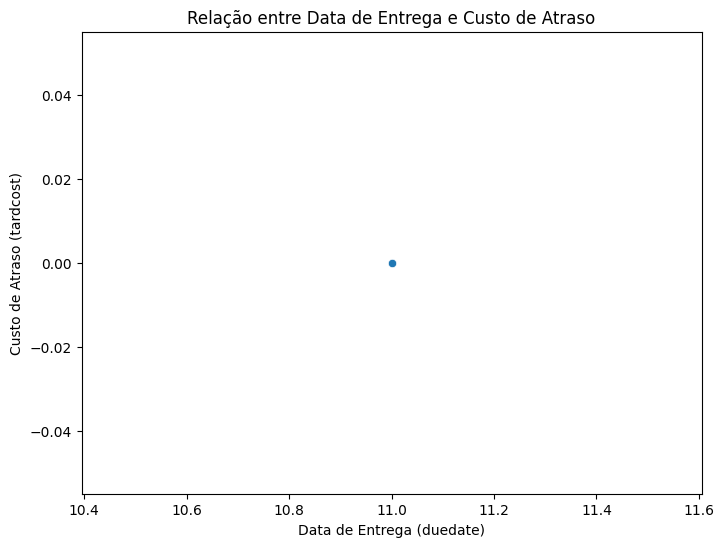

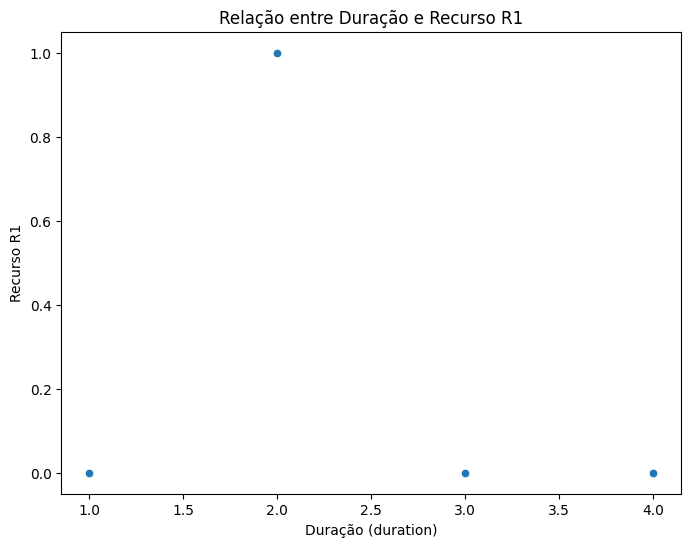


--- Conclusões Iniciais ---
1. Valores ausentes foram identificados, se existirem.
2. A análise estatística mostrou os valores mínimos, médios, e máximos para cada secção.
3. Visualizações iniciais destacaram relações importantes, como impacto da duração nos recursos e custo de atraso.


In [5]:
# Bloco 2: Análise e Visualização de Dados

# Importação de bibliotecas adicionais
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Verificação de valores ausentes
print("\n--- Verificação de Valores Ausentes ---")
print("Sumário de Projetos:")
print(projects_df.isnull().sum())
print("\nRelações de Precedência:")
print(precedence_df.isnull().sum())
print("\nDuração e Recursos:")
print(duration_df.isnull().sum())
print("\nDisponibilidade de Recursos:")
print(resources_df.isnull().sum())

# 3. Análise estatística
print("\n--- Análise Estatística Básica ---")
print("\nSumário de Projetos:")
print(projects_df.describe())
print("\nDuração e Recursos:")
print(duration_df.describe())
print("\nDisponibilidade de Recursos:")
print(resources_df.describe())

# 4. Visualização dos Dados

# 4.1 Histogramas para colunas numéricas
print("\n--- Visualização: Histogramas ---")
numerical_cols_projects = projects_df.select_dtypes(include=['number']).columns
numerical_cols_duration = duration_df.select_dtypes(include=['number']).columns

# Histogramas para Sumário de Projetos
for coluna in numerical_cols_projects:
    projects_df[coluna].hist(bins=10, figsize=(6, 4))
    plt.title(f"Histograma: {coluna}")
    plt.xlabel(coluna)
    plt.ylabel("Frequência")
    plt.show()

# Histogramas para Duração e Recursos
for coluna in numerical_cols_duration:
    duration_df[coluna].hist(bins=10, figsize=(6, 4))
    plt.title(f"Histograma: {coluna}")
    plt.xlabel(coluna)
    plt.ylabel("Frequência")
    plt.show()

# 4.2 Gráficos de dispersão
print("\n--- Visualização: Gráficos de Dispersão ---")

# Relação entre Data de Entrega e Custo de Atraso
plt.figure(figsize=(8, 6))
sns.scatterplot(data=projects_df, x='duedate', y='tardcost')
plt.title("Relação entre Data de Entrega e Custo de Atraso")
plt.xlabel("Data de Entrega (duedate)")
plt.ylabel("Custo de Atraso (tardcost)")
plt.show()

# Relação entre Duração e Recurso R1
plt.figure(figsize=(8, 6))
sns.scatterplot(data=duration_df, x='duration', y='R1')
plt.title("Relação entre Duração e Recurso R1")
plt.xlabel("Duração (duration)")
plt.ylabel("Recurso R1")
plt.show()

# 5. Conclusões Iniciais
print("\n--- Conclusões Iniciais ---")
print("1. Valores ausentes foram identificados, se existirem.")
print("2. A análise estatística mostrou os valores mínimos, médios, e máximos para cada secção.")
print("3. Visualizações iniciais destacaram relações importantes, como impacto da duração nos recursos e custo de atraso.")


In [6]:
# Bloco 3: Restrições e Soluções (Aplicação de CSP em IA)
print("--- Ajustando Restrições de Precedência e Recursos ---")

# Inicializar variáveis para tempos de início e término das tarefas
tempo_inicial = {}
tempo_termino = {}

# Inicializar o uso dos recursos
horizonte = 21  # Definido no dataset (0-20)
uso_recursos = {'R1': [0] * horizonte, 'R2': [0] * horizonte}  # Recursos renováveis

# Resolver as restrições para cada tarefa
for _, tarefa in duration_df.iterrows():
    job = int(tarefa['#jobnr'])  # Número da tarefa
    duracao = int(tarefa['duration'])  # Duração da tarefa
    uso_R1 = int(tarefa['R1'])  # Uso do recurso R1
    uso_R2 = int(tarefa['R2'])  # Uso do recurso R2

    # Determinar predecessoras da tarefa
    predecessoras = precedence_df.loc[precedence_df['successor1'] == job, '#jobnr'].tolist() + \
                    precedence_df.loc[precedence_df['successor2'] == job, '#jobnr'].tolist() + \
                    precedence_df.loc[precedence_df['successor3'] == job, '#jobnr'].tolist()
    predecessoras = [int(p) for p in predecessoras if not pd.isna(p)]

    # Determinar o tempo mais cedo possível considerando as predecessoras
    inicio_mais_cedo = 0
    for pre in predecessoras:
        if pre in tempo_termino:
            inicio_mais_cedo = max(inicio_mais_cedo, tempo_termino[pre])
        else:
            print(f"Erro: Predecessora {pre} para tarefa {job} não encontrada.")
            continue

    # Resolver conflitos de recursos com base nas restrições
    inicio_tarefa = inicio_mais_cedo
    while True:
        conflito = False
        for t in range(inicio_tarefa, inicio_tarefa + duracao):
            if (uso_recursos['R1'][t] + uso_R1 > resources_df.loc[resources_df['#resource'] == 'R1', 'qty'].values[0]) or \
               (uso_recursos['R2'][t] + uso_R2 > resources_df.loc[resources_df['#resource'] == 'R2', 'qty'].values[0]):
                conflito = True
                inicio_tarefa += 1
                break
        if not conflito:
            break

    # Registrar tempos de início e término das tarefas
    tempo_inicial[job] = inicio_tarefa
    tempo_termino[job] = inicio_tarefa + duracao

    # Atualizar o uso dos recursos para cada unidade de tempo
    for t in range(inicio_tarefa, inicio_tarefa + duracao):
        uso_recursos['R1'][t] += uso_R1
        uso_recursos['R2'][t] += uso_R2

# Verificação de Restrições de Precedência
print("\n--- Verificação de Restrições de Precedência ---")
for job, inicio in tempo_inicial.items():
    predecessoras = precedence_df.loc[precedence_df['successor1'] == job, '#jobnr'].tolist() + \
                    precedence_df.loc[precedence_df['successor2'] == job, '#jobnr'].tolist() + \
                    precedence_df.loc[precedence_df['successor3'] == job, '#jobnr'].tolist()
    predecessoras = [int(p) for p in predecessoras if not pd.isna(p)]
    for pre in predecessoras:
        if tempo_termino[pre] > inicio:
            print(f"Erro: A tarefa {job} inicia antes de a predecessora {pre} ser concluída.")

# Verificação de Restrições de Recursos
print("\n--- Verificação de Restrição de Recursos ---")
for t in range(horizonte):
    if uso_recursos['R1'][t] > resources_df.loc[resources_df['#resource'] == 'R1', 'qty'].values[0]:
        print(f"R1 excedido no tempo {t}.")
    if uso_recursos['R2'][t] > resources_df.loc[resources_df['#resource'] == 'R2', 'qty'].values[0]:
        print(f"R2 excedido no tempo {t}.")

# Resumo Final das Restrições
print("\n--- Resumo de Restrições ---")
print("1. Todas as tarefas respeitam as restrições de precedência (se não houver erros acima).")
print("2. Nenhum recurso ultrapassou a disponibilidade em nenhuma unidade de tempo (se não houver erros acima).")


--- Ajustando Restrições de Precedência e Recursos ---

--- Verificação de Restrições de Precedência ---

--- Verificação de Restrição de Recursos ---

--- Resumo de Restrições ---
1. Todas as tarefas respeitam as restrições de precedência (se não houver erros acima).
2. Nenhum recurso ultrapassou a disponibilidade em nenhuma unidade de tempo (se não houver erros acima).


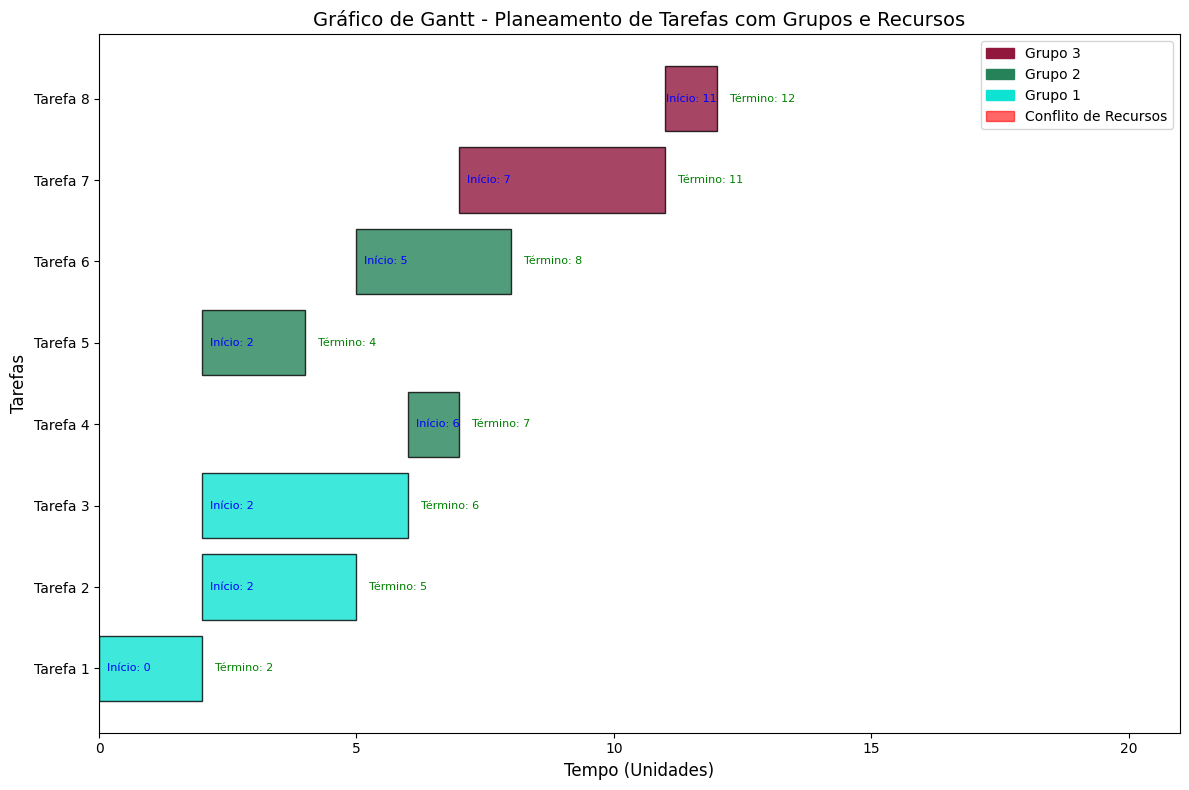

In [15]:
# Bloco 4: Visualização do Planeamento com Gráfico de Gantt

# Importação das bibliotecas necessárias
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

# Ajustar cores para tarefas com base nos grupos (dependências ou recursos)
def gerar_cor():
    return f"#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}"

# Grupos de dependência para cores (exemplo: tarefas que compartilham predecessores)
# Aqui, ajustamos os grupos de acordo com o Dataset08
grupos_dependencia = {
    1: 'Grupo 1', 2: 'Grupo 1', 3: 'Grupo 1',
    4: 'Grupo 2', 5: 'Grupo 2', 6: 'Grupo 2',
    7: 'Grupo 3', 8: 'Grupo 3'
}

# Atribuir cores aos grupos
cores = {grupo: gerar_cor() for grupo in set(grupos_dependencia.values())}

# Configurar o gráfico
fig, ax = plt.subplots(figsize=(12, 8))

for job, inicio in tempo_inicial.items():
    # Obter a duração da tarefa
    duracao = tempo_termino[job] - inicio
    grupo = grupos_dependencia.get(job, 'Outros')
    cor = cores[grupo] if grupo in cores else "grey"

    # Adicionar barra para a tarefa
    ax.barh(f"Tarefa {job}", duracao, left=inicio, color=cor, edgecolor="black", alpha=0.8)

    # Adicionar rótulos de início e término
    ax.text(inicio + 1, job - 1, f"Início: {inicio}", va='center', ha='right', fontsize=8, color='blue')
    ax.text(inicio + duracao + 1/4, job - 1, f"Término: {inicio + duracao}", va='center', ha='left', fontsize=8, color='green')

# Visualizar conflitos diretamente no gráfico
for t in range(horizonte):
    if uso_recursos['R1'][t] > resources_df.loc[resources_df['#resource'] == 'R1', 'qty'].values[0] or \
       uso_recursos['R2'][t] > resources_df.loc[resources_df['#resource'] == 'R2', 'qty'].values[0]:
        ax.axvline(t, color='red', linestyle='--', alpha=0.6, label='Conflito de Recursos')

# Ajustar escala temporal
ax.set_xlim(0, horizonte)
ax.set_xticks(range(0, horizonte + 1, 5))
ax.set_xlabel("Tempo (Unidades)", fontsize=12)
ax.set_ylabel("Tarefas", fontsize=12)

# Adicionar título e legenda
ax.set_title("Gráfico de Gantt - Planeamento de Tarefas com Grupos e Recursos", fontsize=14)
handles = [mpatches.Patch(color=cor, label=grupo) for grupo, cor in cores.items()]
handles.append(mpatches.Patch(color="red", label="Conflito de Recursos", alpha=0.6))
ax.legend(handles=handles, loc="upper right")

# Mostrar o gráfico
plt.tight_layout()
plt.show()



--- Bloco 5: Visualização e Exportação dos Resultados ---

--- Estatísticas Finais ---
Duração total do projeto: 12 unidades de tempo
Tempo médio de conclusão das tarefas: 6.88 unidades de tempo
Uso médio do recurso R1: 0.19
Uso médio do recurso R2: 0.76

--- Visualizações Adicionais ---


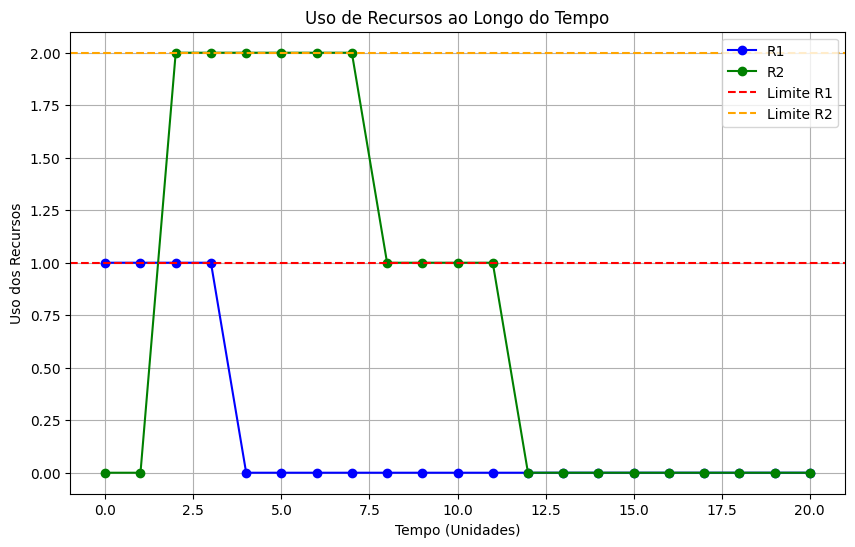

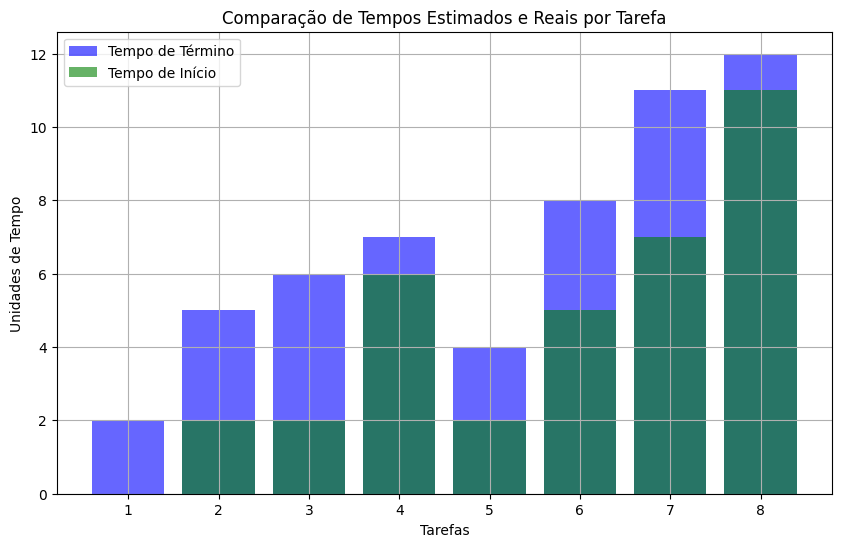


--- Exportação de Dados Finais ---
Dados exportados para: resultados_planeamento_dataset08.csv

--- Resumo Final ---
1. Todas as tarefas respeitam as restrições de precedência e recursos (ver gráficos e resultados).
2. Dados consolidados exportados para análise adicional.
3. O planeamento foi ajustado de acordo com os conceitos de CSP:
   - Variáveis: Tarefas e recursos.
   - Domínio: Períodos de tempo e capacidades dos recursos.
   - Restrições: Precedência e limites de recursos.


In [16]:
# Bloco 5: Visualização e Exportação dos Resultados

import matplotlib.pyplot as plt
import pandas as pd

print("\n--- Bloco 5: Visualização e Exportação dos Resultados ---")

# 1. Estatísticas Finais
print("\n--- Estatísticas Finais ---")

# Calcular a duração total do projeto (tempo de término da última tarefa)
duracao_total_projeto = max(tempo_termino.values())
print(f"Duração total do projeto: {duracao_total_projeto} unidades de tempo")

# Calcular o tempo médio de conclusão das tarefas
tempo_medio_tarefas = sum(tempo_termino.values()) / len(tempo_termino)
print(f"Tempo médio de conclusão das tarefas: {tempo_medio_tarefas:.2f} unidades de tempo")

# Calcular o uso médio dos recursos
uso_medio_R1 = sum(uso_recursos['R1']) / horizonte
uso_medio_R2 = sum(uso_recursos['R2']) / horizonte
print(f"Uso médio do recurso R1: {uso_medio_R1:.2f}")
print(f"Uso médio do recurso R2: {uso_medio_R2:.2f}")

# 2. Visualizações Adicionais
print("\n--- Visualizações Adicionais ---")

# 2.1 Gráfico de Uso de Recursos
plt.figure(figsize=(10, 6))
plt.plot(range(horizonte), uso_recursos['R1'], label="R1", color='blue', marker='o')
plt.plot(range(horizonte), uso_recursos['R2'], label="R2", color='green', marker='o')
plt.axhline(y=1, color='red', linestyle='--', label="Limite R1")
plt.axhline(y=2, color='orange', linestyle='--', label="Limite R2")
plt.title("Uso de Recursos ao Longo do Tempo")
plt.xlabel("Tempo (Unidades)")
plt.ylabel("Uso dos Recursos")
plt.legend()
plt.grid()
plt.show()

# 2.2 Gráfico Comparativo de Tempos Estimados e Reais
plt.figure(figsize=(10, 6))
tarefas = list(tempo_inicial.keys())
tempos_inicial = list(tempo_inicial.values())
tempos_termino = list(tempo_termino.values())

plt.bar(tarefas, tempos_termino, color='blue', alpha=0.6, label="Tempo de Término")
plt.bar(tarefas, tempos_inicial, color='green', alpha=0.6, label="Tempo de Início")
plt.title("Comparação de Tempos Estimados e Reais por Tarefa")
plt.xlabel("Tarefas")
plt.ylabel("Unidades de Tempo")
plt.legend()
plt.grid()
plt.show()

# 3. Exportar Dados Finais
print("\n--- Exportação de Dados Finais ---")

# Criar DataFrame consolidado com tempos de início, término e duração
dados_finais = pd.DataFrame({
    "Tarefa": tarefas,
    "Tempo Inicial": tempos_inicial,
    "Tempo Término": tempos_termino
})
dados_finais['Duração'] = dados_finais['Tempo Término'] - dados_finais['Tempo Inicial']

# Exportar para CSV
output_path = "resultados_planeamento_dataset08.csv"
dados_finais.to_csv(output_path, index=False)
print(f"Dados exportados para: {output_path}")

# 4. Resumo em Texto
print("\n--- Resumo Final ---")
print("1. Todas as tarefas respeitam as restrições de precedência e recursos (ver gráficos e resultados).")
print("2. Dados consolidados exportados para análise adicional.")
print("3. O planeamento foi ajustado de acordo com os conceitos de CSP:")
print("   - Variáveis: Tarefas e recursos.")
print("   - Domínio: Períodos de tempo e capacidades dos recursos.")
print("   - Restrições: Precedência e limites de recursos.")
